<a href="https://colab.research.google.com/github/danthonyrodriguez/Colab-Notebooks/blob/main/Copy_of_Cyber_LogReg_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import plotly.express as px
!pip install tabulate
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 40kB 3.2MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40383 sha256=dc7a66c5638beb6b103a0ecb9abc926764620df868dfb63ca27ab3a291e18eee
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read in the data - This is the CSV that David uploaded to our shared Drive.
#It contains the Q31_Max...Q34_Max variables created by Dylan from Week 1, as well as the PCA factor variables.

df = pd.read_csv('/content/drive/My Drive/DA 6833/merge_wc_edit_update_PCA.csv', na_values = ['9999',"9999", ' ', ''])

# Print the shape of "Update2" CSV
print(df.shape)

df.describe()

(1099, 211)


,DataFileCountryofOrigin,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q3,Q4_1,Q4_2,Q4_3,Q4_4,Q4_5,Q4_6,Q4_7,Q4_8,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q18,Q19,Q20,Q21_1,...,SouthAfrica_dummy,filter_$,hacking_scale,gender_rec,binary_guess_pass,binary_access_account_view_files,binary_add_delete_change,binary_malware_use_delete,binary_private_harassment,binary_malware_use_access,binary_public_harassment,binary_write_malware,CyberTrespass,GAvai_FB,Total_Hour,Male,PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8,PRE_9,PRE_10,PRE_11,PRE_12,PRE_13,PRE_14,PRE_15,Q31_Max,Q32_Max,Q33_Max,Q34_Max,ENI_Factors,BGE_Factors,OGA_Factors,TECH_Factors,PIR_Factors
count,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,456.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,...,1099.000000,1099.0,1095.000000,1097.000000,1096.000000,1097.000000,1098.000000,1098.000000,1098.000000,1098.000000,1097.000000,1097.000000,1094.000000,261.000000,1096.000000,1097.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1080.000000,1081.000000,1081.000000,1081.000000,1081.000000,1080.000000,1080.000000,1056.000000,1055.000000,1099.000000,1099.000000,1099.000000,1099.000000,1.099000e+03,1.099000e+03,1.099000e+03,1.099000e+03,1.099000e+03
mean,1.935396,2.367607,0.683348,0.427662,0.673339,0.226570,0.058235,0.193813,0.070175,3.341219,4.290264,4.330300,3.478617,3.363967,3.510464,2.535032,2.699727,2.347589,5.171329,1.853147,1.374126,1.580420,2.993007,1.688811,2.667832,1.881119,1.811189,1.912587,2.720307,1.409962,3.367816,4.655172,3.773946,4.816092,3.149425,4.961686,3.946360,2.731801,2.076628,1.632184,...,0.260237,1.0,3.694064,0.454877,0.197993,0.154968,0.088342,0.037341,0.046448,0.035519,0.050137,0.038286,6.915905,24.724138,6.729927,0.545123,0.080578,0.080578,0.082799,0.101492,0.084276,0.106565,0.093028,0.084607,0.089719,0.089719,0.084607,0.081141,0.093028,0.112033,0.107718,2.949045,2.890810,3.086442,2.657871,1.082947e-16,3.184188e-16,1.672911e-16,5.479390e-16,1.586033e-16
std,0.762517,0.586340,0.465382,0.494965,0.469205,0.418802,0.234293,0.395464,0.255723,0.919849,0.904555,0.840191,1.239986,1.176738,1.127011,1.247001,1.320605,1.325531,2.199366,0.354580,0.742137,0.494355,0.187186,0.953855,1.174949,0.324216,0.392045,0.282934,2.154229,0.726250,1.732816,1.555345,1.677524,1.704262,1.683829,1.437970,2.131494,1.013801,0.790490,0.882936,...,0.438963,0.0,1.666015,0.498187,0.398669,0.362039,0.283922,0.189681,0.210549,0.185172,0.218327,0.191974,2.478870,5.992989,2.177103,0.498187,0.153038,0.153038,0.152812,0.161207,0.157575,0.161400,0.126327,0.131457,0.126645,0.126645,0.131457,0.130273,0.126327,0.167317,0.162901,1.859634,2.309184,1.783549,2.052889,1.569372e+00,1.510698e+00,1.761044e+00,2.402997e+00,1.857773e+00
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,2.000000,0.000000,0.000198,0.000198,0.000197,0.000912,0.000391,0.001919,0.007889,0.002100,0.003767,0.003767,0.002100,0.007700,0.007889,0.001788,0.001573,0.000000,0.000000,0.000000,0.000000,-2.037903e+00,-2.384420e+00,-4.078790e+00,-5.054668e+00,-3.306052e+00
25%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,4.000000,2.000000,3.000000,3

In [ ]:
### Step 1: Constructing Train and Test Sets for Logistic Regression
### I am going to grab only the relevant variables from our initial data set - The "Update_PCA" CSV. 

Data = df[['NO','DataFileCountryofOrigin','Q14','Q5','Q23', 'Q24','Q25', 'Q27', 'Q28','Q39', 'Q40', 'Q41', 'Q42', 
            'Q31_Max', 'Q32_Max','Q33_Max', 'Q34_Max', 'Male','ENI_Factors', 'BGE_Factors','OGA_Factors', 'TECH_Factors', 
            'PIR_Factors', 'Q26_1', 'Q26_4', 'Q36_16', 'Q36_18']]

Data = Data.set_index("NO")

print(Data.shape)

Data.head()

(1099, 26)


,DataFileCountryofOrigin,Q14,Q5,Q23,Q24,Q25,Q27,Q28,Q39,Q40,Q41,Q42,Q31_Max,Q32_Max,Q33_Max,Q34_Max,Male,ENI_Factors,BGE_Factors,OGA_Factors,TECH_Factors,PIR_Factors,Q26_1,Q26_4,Q36_16,Q36_18
NO,,,,,,,,,,,,,,,,,,,,,,,,,,
sg1,2,NaN,NaN,NaN,NaN,NaN,3.0,2.0,1,NaN,5,1,1.0,2.0,2.0,2.0,NaN,0.410557,1.365297,0.066123,1.690926,1.320077,3,5.0,3.0,3.0
en38,2,NaN,NaN,NaN,NaN,NaN,5.0,2.0,0,NaN,0,0,2.0,2.0,2.0,2.0,NaN,-1.612441,8.128382,2.822864,-2.622617,-0.511065,2,2.0,3.0,4.0
re25,2,NaN,NaN,NaN,NaN,NaN,2.0,4.0,3,NaN,1,1,5.0,2.0,2.0,2.0,0.0,0.815450,0.673172,-1.527111,2.153578,0.296094,5,4.0,3.0,3.0
re47,2,NaN,NaN,NaN,NaN,NaN,1.0,4.0,3,NaN,1,1,3.0,2.0,3.0,2.0,0.0,0.469872,-1.689587,-0.095561,-0.398677,-1.908558,4,3.0,1.0,3.0
re44,2,NaN,NaN,NaN,NaN,NaN,1.0,5.0,5,NaN,2,2,2.0,0.0,8.0,0.0,0.0,2.409520,2.858529,-1.960660,2.564042,-1.101400,6,2.0,3.0,3.0


In [ ]:
### Renaming columns for ease of interpretation later

Data = Data.rename(columns={"Q31_Max": "phy_for_intensity", "Q32_Max": "cyb_for_intensity",
                            "Q33_Max":"phy_hom_intensity","Q34_Max":"cyb_hom_intensity",
                            "DataFileCountryofOrigin": "Country", "Q14":"Facebook",
                           "Q5":"AccessInternetAccounts","Q23":"TrustNewsFBPerson", 
                            "Q24": "TrustNewsFBGral", "Q25": "TrustMost",
                           "Q27": "HrsCompWorkSchool", "Q28":"HrsCompNotWorkSchool",
                           "Q39": "Educ_Level", "Q40":"University", "Q41":"Employment",
                           "Q42":"MaritalStatus","Q26_1": "ChatroomHRS","Q26_4": "InformationSearches","Q36_16": "SportCompWin","Q36_18": "UseForce"})


Data.shape ### I have 1099 rows with 22 columns
Data.columns


Index(['Country', 'Facebook', 'AccessInternetAccounts', 'TrustNewsFBPerson',
       'TrustNewsFBGral', 'TrustMost', 'HrsCompWorkSchool',
       'HrsCompNotWorkSchool', 'Educ_Level', 'University', 'Employment',
       'MaritalStatus', 'phy_for_intensity', 'cyb_for_intensity',
       'phy_hom_intensity', 'cyb_hom_intensity', 'Male', 'ENI_Factors',
       'BGE_Factors', 'OGA_Factors', 'TECH_Factors', 'PIR_Factors',
       'ChatroomHRS', 'InformationSearches', 'SportCompWin', 'UseForce'],
      dtype='object')

In [ ]:
### More data clean up: I am dropping a couple rows because their 'Male' value is blank.

Data = Data.drop(['sg1', 'en38'])
Data = Data.round(2)
Data = Data.fillna(0)
Data.shape

(1097, 26)

In [ ]:
### This function categorizes the 4 attack intensity variables into low, medium or high. From Hiwot Girma's code.

def createCyberIntensity(row, col_name):
  if(row[col_name]<=1):
    return 'low'
  if(row[col_name] >1 and row[col_name]<=4):
    return 'medium'
  else:
    return 'high'

In [ ]:
### Now we are applying the low/medium/high funciton to the 4 attack intensity variables (originally, the 'max value' variables)

Data['cyb_hom_intensity'] = Data.apply (lambda row: createCyberIntensity(row, 'cyb_hom_intensity'), axis=1)
Data['cyb_for_intensity'] = Data.apply (lambda row: createCyberIntensity(row, 'cyb_for_intensity'), axis=1)
Data['phy_for_intensity'] = Data.apply (lambda row: createCyberIntensity(row, 'phy_for_intensity'), axis=1)
Data['phy_hom_intensity'] = Data.apply (lambda row: createCyberIntensity(row, 'phy_hom_intensity'), axis=1)

In [ ]:
### Now I'm going to take a look at the distributions of the 4 categorized attack intensity variables.
CybHomeIntense = px.histogram(Data, x='cyb_hom_intensity', title="Distribution of Cyber Home Intensity") 
CybHomeIntense.show()

CybForeignIntense = px.histogram(Data, x='cyb_for_intensity', title="Distribution of Cyber Foreign Intensity") 
CybForeignIntense.show()

PhyHomeIntense = px.histogram(Data, x='phy_hom_intensity', title="Distribution of Physical Home Intensity") 
PhyHomeIntense.show()


PhyForeignIntense = px.histogram(Data, x='phy_for_intensity', title="Distribution of Physical Foreign Intensity") 
PhyForeignIntense.show()


In [ ]:
#this function is used to create a binary (0 or 1 ) target variable based on the categorized intensity variables for example, high cyber attack =1 else 0. 
def createTarget(row, col_name):
  if(row[col_name]=='high'):
    return 1
  else:
    return 0

In [ ]:
#Applying the binary target variable function to the 4 attack intensity variables

Data['cyb_hom_target'] =Data.apply (lambda row: createTarget(row, 'cyb_hom_intensity'), axis=1)
Data['cyb_for_target'] =Data.apply (lambda row: createTarget(row, 'cyb_for_intensity'), axis=1)
Data['phy_hom_target'] =Data.apply (lambda row: createTarget(row, 'phy_hom_intensity'), axis=1)
Data['phy_for_target'] =Data.apply (lambda row: createTarget(row, 'phy_for_intensity'), axis=1)

In [ ]:
### Our 4 target variables are now in binary form and they are: ['cyb_hom_target','cyb_for_target', 'phy_hom_target', 'phy_for_target']

In [ ]:
#Initial variable selection
pred_vars_all =['Country', 'Facebook', 'AccessInternetAccounts', 'TrustNewsFBPerson',
                'TrustNewsFBGral', 'TrustMost', 'HrsCompWorkSchool','HrsCompNotWorkSchool', 
                'Educ_Level', 'Employment','MaritalStatus', 
                'ENI_Factors','OGA_Factors', 'TECH_Factors', 'PIR_Factors']


In [ ]:
### Here I am determining Predictive and Target Variables

x = Data[pred_vars_all]

y_1 = Data['cyb_hom_target']
y_2 = Data['cyb_for_target']
y_3 = Data['phy_hom_target']
y_4 = Data['phy_for_target']

In [ ]:
# scale target variables for multinomial logistic regression (Low, Medium, High)
y_1_scale = Data['cyb_hom_intensity']
y_2_scale = Data['cyb_for_intensity']
y_3_scale = Data['phy_hom_intensity']
y_4_scale = Data['phy_for_intensity']

### 1. Cyber Attack - Home (80% Accuracy)

In [ ]:
### Step 2: Split Data into train and test. 

x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x, y_1, test_size=.2, random_state=0)

print("X Train Shape:", x_1_train.shape)
print("Y Train Shape:", y_1_train.shape)
print("X Test Shape:", x_1_train.shape)
print("Y Test Shape:", y_1_train.shape)

#Checking if target is unbalanced or not. 210 / 879. About 24%. Not so bad. ///// 
target = y_1_train.to_frame()
fig = px.histogram(target, x='cyb_hom_target', title="Target Variable - check if unbalanced") 
#fig.show()


X Train Shape: (877, 15)
Y Train Shape: (877,)
X Test Shape: (877, 15)
Y Test Shape: (877,)


In [ ]:
### Fit Logistic Regression model on Cyber Home Target
logmodel1 = LogisticRegression(max_iter=1000)
logmodel1.fit(x_1_train,y_1_train)
predictions = logmodel1.predict(x_1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel1.score(x_1_test, y_1_test)))
confusion_matrix(y_1_test, predictions)
print(classification_report(y_1_test,predictions))

Accuracy of logistic regression classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       175
           1       1.00      0.04      0.09        45

    accuracy                           0.80       220
   macro avg       0.90      0.52      0.49       220
weighted avg       0.84      0.80      0.73       220



### 2. Cyber Attack - Foreign (76% Accuracy)




In [ ]:
### Step 1: Split Data into train and test. 

x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x, y_2, test_size=.2, random_state=0)

print("X Train Shape:", x_2_train.shape)
print("Y Train Shape:", y_2_train.shape)
print("X Test Shape:", x_2_train.shape)
print("Y Test Shape:", y_2_train.shape)

#Checking if target is unbalanced or not. 210 / 879. About 24%. Not so bad.
target = y_2_train.to_frame()
fig = px.histogram(target, x='cyb_for_target', title="Target Variable - check if unbalanced") 
#fig.show()


X Train Shape: (877, 15)
Y Train Shape: (877,)
X Test Shape: (877, 15)
Y Test Shape: (877,)


In [ ]:
### Step : Fit Logistic Regression model on Cyber Foreign Attack
logmodel2 = LogisticRegression(max_iter=1000)
logmodel2.fit(x_2_train,y_2_train)
predictions = logmodel2.predict(x_2_test)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel2.score(x_2_test, y_2_test)))

### Print Confusion Matrix
confusion_matrix(y_2_test, predictions)

### Print Classification Report
print(classification_report(y_2_test,predictions))

Accuracy of logistic regression classifier on test set: 0.76
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       169
           1       0.43      0.06      0.10        51

    accuracy                           0.76       220
   macro avg       0.60      0.52      0.48       220
weighted avg       0.69      0.76      0.69       220



### 3. Physical Home Target (71% Accuracy)

In [ ]:
### Step 1: Split Data into train and test. 

x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(x, y_3, test_size=.2, random_state=0)

print("X Train Shape:", x_3_train.shape)
print("Y Train Shape:", y_3_train.shape)
print("X Test Shape:", x_3_train.shape)
print("Y Test Shape:", y_3_train.shape)

#Checking if target is unbalanced or not. 210 / 879. About 24%. Not so bad.
target = y_3_train.to_frame()
fig = px.histogram(target, x='phy_hom_target', title="Target Variable - check if unbalanced") 
#fig.show()


X Train Shape: (877, 15)
Y Train Shape: (877,)
X Test Shape: (877, 15)
Y Test Shape: (877,)


In [ ]:
### Step : Fit Logistic Regression model on Physical Home Attack

logmodel3 = LogisticRegression(max_iter=1000)
logmodel3.fit(x_3_train,y_3_train)
predictions = logmodel3.predict(x_3_test)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel3.score(x_3_test, y_3_test)))

### Print Confusion Matrix
confusion_matrix(y_3_test, predictions)

### Print Classification Report
print(classification_report(y_3_test,predictions))


Accuracy of logistic regression classifier on test set: 0.71
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       157
           1       0.00      0.00      0.00        63

    accuracy                           0.71       220
   macro avg       0.36      0.50      0.42       220
weighted avg       0.51      0.71      0.59       220



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### 4. Physical Foreign Target (75% Accuracy)

In [ ]:
### Step 1: Split Data into train and test. 

x_4_train, x_4_test, y_4_train, y_4_test = train_test_split(x, y_4, test_size=.2, random_state=0)

print("X Train Shape:", x_4_train.shape)
print("Y Train Shape:", y_4_train.shape)
print("X Test Shape:", x_4_train.shape)
print("Y Test Shape:", y_4_train.shape)

#Checking if target is unbalanced or not. 
target = y_4_train.to_frame()
fig = px.histogram(target, x='phy_for_target', title="Target Variable - check if unbalanced") 
#fig.show()


X Train Shape: (877, 15)
Y Train Shape: (877,)
X Test Shape: (877, 15)
Y Test Shape: (877,)


In [ ]:
### Step 2 : Fit Logistic Regression model on Physical Foreign Attack

logmodel4 = LogisticRegression(max_iter=1000)
logmodel4.fit(x_4_train,y_4_train)
predictions = logmodel4.predict(x_4_test)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel4.score(x_4_test, y_4_test)))

### Print Confusion Matrix
confusion_matrix(y_4_test, predictions)

### Print Classification Report
print(classification_report(y_4_test,predictions))

Accuracy of logistic regression classifier on test set: 0.75
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       165
           1       0.33      0.02      0.03        55

    accuracy                           0.75       220
   macro avg       0.54      0.50      0.44       220
weighted avg       0.65      0.75      0.65       220



In [ ]:
x.columns

Index(['Country', 'Facebook', 'AccessInternetAccounts', 'TrustNewsFBPerson',
       'TrustNewsFBGral', 'TrustMost', 'HrsCompWorkSchool',
       'HrsCompNotWorkSchool', 'Educ_Level', 'Employment', 'MaritalStatus',
       'ENI_Factors', 'OGA_Factors', 'TECH_Factors', 'PIR_Factors'],
      dtype='object')

### Multinomial Logistic Regression



**Multinomial Logistic Regression - y_1_scale = Cyber Home Intensity**



In [ ]:
x_1_scaletrain, x_1_scaletest, y_1_scaletrain, y_1_scaletest = train_test_split(x, y_1_scale, test_size=.2, random_state=0)

### define the multinomial logistic regression model
multi1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multi1.fit(x_1_scaletrain,y_1_scaletrain)
predictions = multi1.predict(x_1_scaletest)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(multi1.score(x_1_scaletest, y_1_scaletest)))

### Print Confusion Matrix
print(confusion_matrix(y_1_scaletest, predictions))

### Print Classification Report
print(classification_report(y_1_scaletest,predictions))


#model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 1000)
#cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
#n_scores = cross_val_score(model, x, y_1_scale, scoring = 'accuracy', cv = cv, n_jobs = 1)
#print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy of logistic regression classifier on test set: 0.57
[[  5  10  30]
 [  2  19  34]
 [  3  15 102]]
              precision    recall  f1-score   support

        high       0.50      0.11      0.18        45
         low       0.43      0.35      0.38        55
      medium       0.61      0.85      0.71       120

    accuracy                           0.57       220
   macro avg       0.52      0.44      0.43       220
weighted avg       0.55      0.57      0.52       220



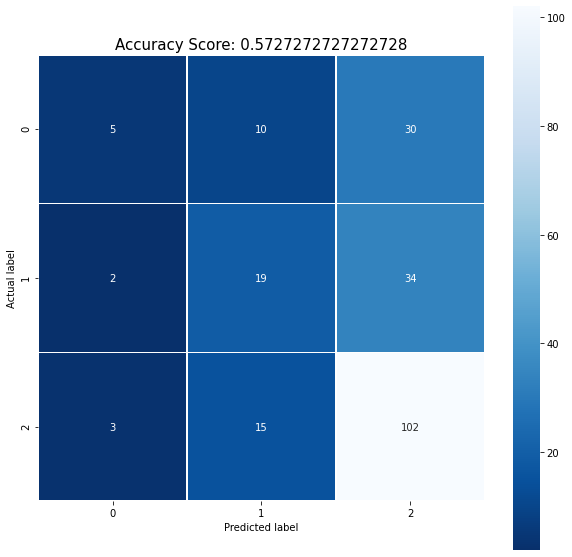

In [ ]:
cm = metrics.confusion_matrix(y_1_scaletest, predictions)
score = multi1.score(x_1_scaletest, y_1_scaletest)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
y_1_scale.unique()

array(['medium', 'low', 'high'], dtype=object)

**Multinomial Logistic Regression - y_2_scale = Cyber Foreign Intensity**

**Multinomial Logistic Regression - y_3_scale = Physical Home Intensity**

Accuracy of logistic regression classifier on test set: 0.44
[[ 1 17 45]
 [ 3 23 31]
 [ 7 21 72]]
              precision    recall  f1-score   support

        high       0.09      0.02      0.03        63
         low       0.38      0.40      0.39        57
      medium       0.49      0.72      0.58       100

    accuracy                           0.44       220
   macro avg       0.32      0.38      0.33       220
weighted avg       0.34      0.44      0.37       220



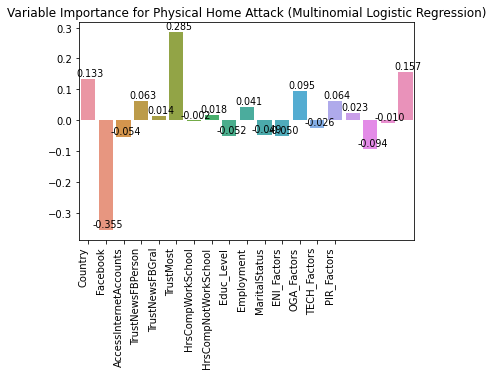

Accuracy of logistic regression classifier on test set: 0.44
[[ 2 16 45]
 [ 3 18 36]
 [ 7 16 77]]
              precision    recall  f1-score   support

        high       0.17      0.03      0.05        63
         low       0.36      0.32      0.34        57
      medium       0.49      0.77      0.60       100

    accuracy                           0.44       220
   macro avg       0.34      0.37      0.33       220
weighted avg       0.36      0.44      0.37       220



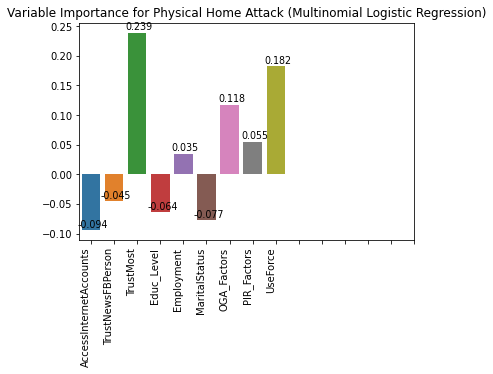

In [ ]:
#The above questions are: 26_1 - hours per week in chatrooms, 26_4 - hours per week doing information searches, 
#36_16 - importance of country winning in sports, 36_18 - sometimes necessary to use force, 
pred_vars_all =['Country', 'Facebook', 'AccessInternetAccounts', 'TrustNewsFBPerson',
                'TrustNewsFBGral', 'TrustMost', 'HrsCompWorkSchool','HrsCompNotWorkSchool', 
                'Educ_Level', 'Employment','MaritalStatus', 
                'ENI_Factors','OGA_Factors', 'TECH_Factors', 'PIR_Factors', 'ChatroomHRS', 'InformationSearches', 'SportCompWin', 'UseForce']

x = Data[pred_vars_all]



x_3_scaletrain, x_3_scaletest, y_3_scaletrain, y_3_scaletest = train_test_split(x, y_3_scale, test_size=.2, random_state=0)

### define the multinomial logistic regression model
multi3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multi3.fit(x_3_scaletrain,y_3_scaletrain)
predictions = multi3.predict(x_3_scaletest)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(multi3.score(x_3_scaletest, y_3_scaletest)))

### Print Confusion Matrix
print(confusion_matrix(y_3_scaletest, predictions))

### Print Classification Report
print(classification_report(y_3_scaletest,predictions))

# Variable Importance for Cyber Home Attack
importance3 = multi3.coef_[0]
a = [z for z in range(len(importance3))]
ax = sns.barplot(x = a, y = importance3, data = x)
ax.set(title = 'Variable Importance for Physical Home Attack (Multinomial Logistic Regression)')
plt.xticks(range(15), x, rotation = 90, ha = 'right')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', xytext = (2, 3), textcoords = 'offset points', size = 9.5)

plt.show()
#Select new variables from importance plots
pred_vars_1 = ['AccessInternetAccounts', 'TrustNewsFBPerson', 'TrustMost',
                'Educ_Level', 'Employment','MaritalStatus', 
                'OGA_Factors', 'PIR_Factors', 'UseForce'] 
x = Data[pred_vars_1]

x_3_scaletrain, x_3_scaletest, y_3_scaletrain, y_3_scaletest = train_test_split(x, y_3_scale, test_size=.2, random_state=0)

### define the multinomial logistic regression model
multi3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multi3.fit(x_3_scaletrain,y_3_scaletrain)
predictions = multi3.predict(x_3_scaletest)

### Print Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(multi3.score(x_3_scaletest, y_3_scaletest)))

### Print Confusion Matrix
print(confusion_matrix(y_3_scaletest, predictions))

### Print Classification Report
print(classification_report(y_3_scaletest,predictions))

# Variable Importance for Cyber Home Attack
importance3 = multi3.coef_[0]
a = [z for z in range(len(importance3))]
ax = sns.barplot(x = a, y = importance3, data = x)
ax.set(title = 'Variable Importance for Physical Home Attack (Multinomial Logistic Regression)')
plt.xticks(range(15), x, rotation = 90, ha = 'right')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', xytext = (2, 3), textcoords = 'offset points', size = 9.5)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 1000)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_scores = cross_val_score(model, x, y_3_scale, scoring = 'accuracy', cv = cv, n_jobs = 1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.454 (0.021)


**Multinomial Logistic Regression - y_4_scale = Physical Foreign Intensity**


# Plots / scratch work ignore


**Multinomial Logistic Regression: y_1 = Cyber Attack Home**


In [ ]:
pip install latex

>0.00 0.529 (0.011)
>0.01 0.525 (0.030)
>0.10 0.524 (0.027)
>1.00 0.521 (0.030)


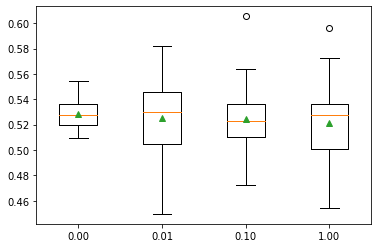

In [ ]:
## Multinomial Logistic Regression: y_1_scale = Cyber Attack Home

# tune regularization for multinomial logistic regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
	#return X, y
  return x, y_1_scale
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
		# create name for model
		key = '%.2f' % p
		# turn off penalty in some cases
		if p == 0.0:
			# no penalty in this case
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
		else:
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()